<a href="https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/RSNA2021_YOLOv5_Workshop/blob/master/Train_YOLOv5_Full_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Brain Hemorrhage Detection Model

Welcome to the RSNA2021 Object detection workshop!

In this notebook, we train a YOLOv5 deep learning model to detect brain hemorrhage on Head CT scans. 

*  For our model, we use the [Ultralytics](https://github.com/ultralytics/yolov5) implementation of YOLOv5.
*  For our data, we use the publicly available [CQ500 Head CT-scan dataset](http://headctstudy.qure.ai/dataset) of patients with brain hemorrhage. 
*  For our labels, we use the bounding box annotation on CQ500 dataset by [Physionet](https://physionet.org/content/bhx-brain-bounding-box/1.1/).

Hopefully, by reviewing this notebook you will be able to train a model that can detect hemorrhage lesions on brain CT scans, as plotted in the image below:
<center><img src='https://drive.google.com/uc?export=download&id=1Jgl42NBR79DK62QxMXFHGdFFGQYTORB1'</img></center>

In this notebook, you are supposed to complete a few coding blocks in different cells. This will help you to think better about the processes we need to take for training and applying our model. Don't worry, in case you did not find out the right code to put in the cells, we will provide it to you. We are all learning after all!


### Part 0: Setting up the working directory
We start our work by installing some required libraries and cloning our DICOMs and ground truths from a GitHub repository that we have made before. In this notebook, we will train our model on 3500 DICOMs from the CQ500 dataset. Feel free to download the entire dataset and train stronger models on it after this workshop!

In [2]:
# Installing required packages

!pip uninstall scikit-learn -y
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install python-gdcm pydicom
!pip uninstall PyYAML -y
!pip install PyYAML==5.3.1

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.9 MB 10.7 MB/s 
     |████████████████████████████████| 9.4 MB 20.8 MB/s 
     |████████████████████████████████| 2.0 MB 45.5 MB/s 
Found existing installation: PyYAML 3.13
Uninstalling PyYAML-3.13:
  Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 269 kB 34.7 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44635 sha256=c7695e4dcbe992e08f90a58f5c1e12ecfc84cc2a73bf080dcec3cd598e6f9610
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML


In [3]:
# Removing the "sample_data" folder that google colab creates by default

import shutil
shutil.rmtree('sample_data', ignore_errors=True)

In [4]:
# Importing DICOM and label files to our working directory
%%time

!git clone https://github.com/Mayo-Radiology-Informatics-Lab/RSNA2021_YOLOv5_Workshop.git

Cloning into 'RSNA2021_YOLOv5_Workshop'...
remote: Enumerating objects: 3715, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 3715 (delta 35), reused 142 (delta 25), pack-reused 3563
Receiving objects: 100% (3715/3715), 570.96 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (3561/3561), done.
CPU times: user 431 ms, sys: 69.7 ms, total: 500 ms
Wall time: 31.3 s


OK, now feel free to check your working directory on the right side of the screen. You should click on the folder icon and will then see a folder named "RSNA2021_YOLOv5_Workshop". If you look inside that folder, you will see a folder containing our DICOM files and a CSV file containing our labels.

### Part 1: Extracting CT images out of DICOMs
YOLO works on 2-dimensional images, therefore we need to convert our DICOM files to images before we can train a model on them. For this, we first create a list of paths to all our DICOMs, then read each DICOM with Pydicom library, and finally convert the DICOM arrays to PNG images, while bringing them to the brain window.

In [5]:
# Collecting the paths to DICOM files

import os

DICOMs_dir = 'RSNA2021_YOLOv5_Workshop/DICOMs'
dcmpaths = list()
for root, dirs, files in os.walk(DICOMs_dir):
    for file in files:
        if file.endswith('.dcm'):
            dcmpaths.append(os.path.join(root, file))

print(f'{len(dcmpaths)} DICOMs were found!')

3558 DICOMs were found!


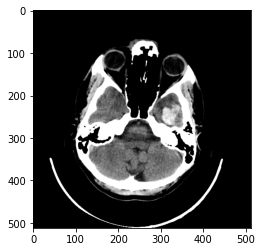

In [6]:
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)


def Apply_window(img, ww=80, wl=40):
    """
    A function to apply windowing on the CT-scan. Default values represent the brain window.
    """
    U = 255
    W = U / ww
    b = (-U/ww) * (wl-ww/2)
    img = W*img + b
    img = np.where(img > U, U, img)
    img = np.where(img < 0, 0, img)
    return img

def Extract_image(dcmpath, test_run=False):
    """
    Extract imaging array out of a given DICOM file.
    """
    # Extracting the pixel_array as img 
    dcm = dcmread(dcmpath)
    img = dcm.pixel_array
    
    # Converting the pixel values to HU
    # We can do this conversion by multiplying each value in our img array in 
    # the DICOM slope and adding that with the DICOM intercept (like a linear
    # equasion). DICOMs have two tags that can be used for this purpose: 
    # RescaleIntercept and RescaleSlope

    ##### START YOUR CODE HERE: 
    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    img = slope * img + intercept
    ##### END YOUR CODE HERE.

    # Widnowing to the brain window
    img = Apply_window(img)
    
    # Normalizing and changing the img to 8-bit.
    img -= img.mean()
    img /= (img.std() + 1e-10)
    img -= img.min()
    img = (255 * img/np.max(img)).astype('uint8')
    
    # Saving the img as a PNG file to images_dir
    # A DICOM's name is : {SOPInstanceUID}.dcm
    # We name the image files similiarly: {SOPInstanceUID}.png
    
    pil_img = Image.fromarray(img)
    pil_img.save(f'{images_dir}/{dcmpath.split("/")[-1][:-4]}.png')
    
    # Testing the function's performance if needed
    if test_run:
        plt.imshow(pil_img, cmap='gray')
    
# Testing the Extract_image function
Extract_image(dcmpaths[400], test_run=True)

In [7]:
# Extracting CT images out of all DICOMs 

from tqdm import tqdm

for dcmpath in tqdm(dcmpaths):
    Extract_image(dcmpath)

100%|██████████| 3558/3558 [02:06<00:00, 28.02it/s]


In [8]:
# Collecting the paths to all saved images

imgpaths = [os.path.join('images', file) for file in os.listdir('images')]
print(f'{len(imgpaths)} images were found!')

3558 images were found!


OK, now check your working directory again. You should see a folder named "images" in which you should find all images from our dataset.

### Part 2: Collecting and visualizing the annotated bounding box labels
Now that we took care of the images, let's take a look at our ground truth labels. For this, we use Pandas to load our annotation CSV file.

In [9]:
# Importing our annotation dataset as a Pandas dataframe

import pandas as pd

labels_csv_path = 'RSNA2021_YOLOv5_Workshop/labels.csv'
labels_df = pd.read_csv(labels_csv_path)

num_bboxes = len(labels_df)
num_unique_images = len(pd.unique(labels_df.SOPInstanceUID))
num_unique_scans = len(pd.unique(labels_df.SeriesInstanceUID))                    
print (f'The dataframe includes {num_bboxes} bounding boxes from {num_unique_images} images and {num_unique_scans} scans!\n')

labels_df.head()

The dataframe includes 6283 bounding boxes from 3558 images and 233 scans!



,Unnamed: 0,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,data,labelName,labelType
0,95,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 236.16402999999997, 'y': 151.01577, 'wid...",Intraventricular,handDrawn
1,96,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 232.93374, 'y': 156.66877, 'width': 57.3...",Intraventricular,handDrawn
2,97,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 230.51106000000001, 'y': 147.78548999999...",Intraventricular,handDrawn
3,98,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 224.05046000000002, 'y': 151.82334, 'wid...",Intraventricular,handDrawn
4,99,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 287.04103, 'y': 297.99369, 'width': 52.4...",Intraventricular,handDrawn


Looking at the above dataframe, please note two things:
that we do not have the names of PatientIDs of patients in our dataset. Our 

1.   Each Row in our dataframe belongs to one single **bounding box** for a hemorrhage lesion (and not a CT slice or nor a patient). So each slice of a CT scan may be on more than one row if it contains more than one hemorrhage lesion!
2.   DICOMs are also de-identified and do not have a PatientID tag, yet they do have *StudyInstanceUID* tags. We will soon talk about this more!

In [10]:
# Finding out the possible labels and assigning a color to each label

all_possible_labels = set(labels_df.labelName.tolist())
colors = ['red', 'blue', 'green', 'orange', 'pink', 'purple']
label_color_dict = {label:color for label, color in zip(all_possible_labels, colors)}

for label in label_color_dict.keys():
    print(f'{label}: {label_color_dict[label]}')

Intraparenchymal: red
Subarachnoid: blue
Chronic: green
Subdural: orange
Intraventricular: pink
Epidural: purple


It's a good idea to plot some images and their manually plotted bounding boxes before we start the training. This will help us have a better sense of what data we are dealing with. Feel free to run the cell below a few times and see multiple different images with their annotations.

Intraparenchymal: red
Subarachnoid: blue
Chronic: green
Subdural: orange
Intraventricular: pink
Epidural: purple


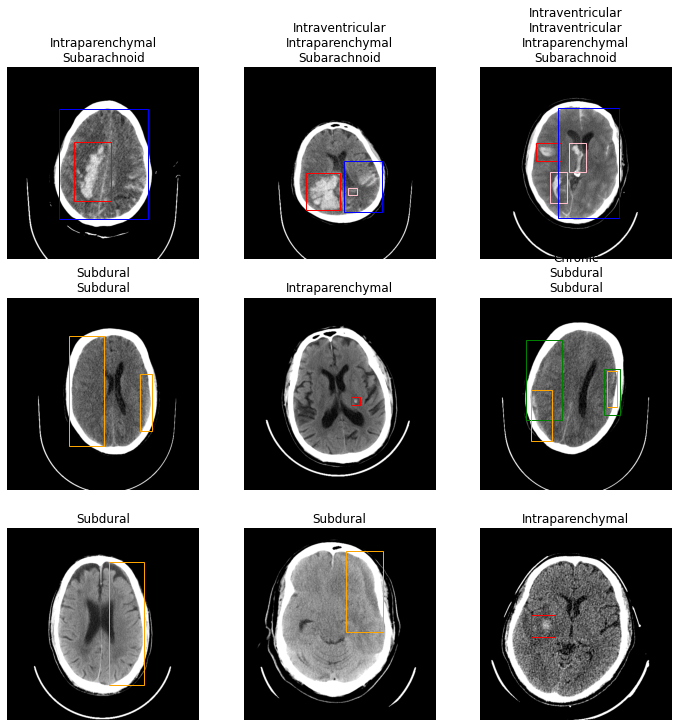

In [11]:
# Plotting random sample images along with their annotated bounding boxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
import ast

def Collect_GT_bboxes(imgpath):
    """
    Collect ground truth (manually annotated) bounding box coordinates for a given imgpath.
    """
    sop_uid = imgpath.split('/')[-1][:-4]
    img_df = labels_df[labels_df.SOPInstanceUID==sop_uid]
    bboxes = list()
    for i, row in img_df.iterrows():
        bbox = ast.literal_eval(row['data'])
        bbox['labelName'] = row['labelName']
        bboxes.append(bbox)
    return bboxes    

# Plot bboxes on 9 random imgpaths
from random import choices
sample_imgpaths = choices(imgpaths, k=9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        imgpath = sample_imgpaths[i*3 + j]
        img = imread(imgpath)
        bboxes = Collect_GT_bboxes(imgpath)
        axes[i, j].imshow(img, cmap='gray')
        labels = list()
        for bbox in bboxes:
            xmin = bbox['x'] 
            ymin = bbox['y']
            label = bbox['labelName']
            labels.append(label)
            rect = patches.Rectangle((xmin, ymin), bbox['width'], bbox['height'], 
                                     linewidth=1, 
                                     edgecolor=label_color_dict[label], 
                                     facecolor='none')
            axes[i, j].add_patch(rect)
        axes[i, j].axis('off')
        axes[i, j].set_title('\n'.join(labels))
for label in label_color_dict.keys():
    print(f'{label}: {label_color_dict[label]}')

### Part 3: Data splitting and setting up the training and validation files

**Ideally, we would like to split our data into different sets (training, validation, test) based on PatientIDs. Here, we need to do the split based on StudyInstanceUID, which we assume are unique for each patient (A patient may have multiple studies and a study may contain more than one scan, yet we assume that each patient in our pool has only one study)**. DICOMs also have *SeriesInstanceUID* tags that are the same for all DICOMs from a single CT scan, but different between scans, and *SOPInstanceUID* tags, which are unique for each DICOM regardless of the patient or the scan it belongs to. 

Saying above, let's start splitting our data to a training and a validation set. Ideally, we would like to also have a test set or endorse a k-fold cross-validation strategy, yet we keep things simple for this workshop!

In [12]:
# Building the folders needed for data splitting
# These folders will be added to our working directory.

train_imgs_dir = 'model_data/images/train'
train_labels_dir = 'model_data/labels/train'
valid_imgs_dir = 'model_data/images/valid'
valid_labels_dir = 'model_data/labels/valid'

os.makedirs(train_imgs_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(valid_imgs_dir, exist_ok=True)
os.makedirs(valid_labels_dir, exist_ok=True)

Here we create three lists based on our dataframe: 

*   X: A list of all SOPInstanceUIDs we got from all rows (don't forget that each DICOM has a unique SOPInstanceUID, so this list includes all our DICOM names).
*   Y: A list of all labels (or the types of hemorrhage lesions) for all rows.
*   groups: A list of all StudyInstanceUIDs.

What we need to do, is to split our X into 2 different folds (80% training and 20% validation), while controlling for the group variable (so that all rows for one specific StudyInstaceUID tag go to either training or validation sets) and also stratifying our data based on the labels (so that the distribution of different labels between training and validation sets be as close as possible to our 80-20 split).

How should we do that? Let's have you try it first!

In [13]:
# Splitting the data into training and validation sets.

X = labels_df.SOPInstanceUID.tolist()
Y = labels_df.labelName.tolist()
groups = labels_df.StudyInstanceUID.tolist()

# Use the above lists to split our labels_df into two seperate dataframes for 
# training (train_df) and validation (valid_df). Don't forget to control the 
# split based on the groups and straitfy that based on the labels! Training to 
# validation ration should be 80/20.
# Also generate two sets of StudyInstanceUIDs; one for training data and one for
# validation data, so that we can test our pipeline! (look at the print commands
# below):

##### START YOUR CODE HERE: 
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5)
train_idxs, valid_idxs = next(iter(cv.split(X, Y, groups)))
train_df = labels_df.loc[train_idxs]
valid_df = labels_df.loc[valid_idxs]
train_uids = set(train_df.StudyInstanceUID.tolist())
valid_uids = set(valid_df.StudyInstanceUID.tolist())
##### END YOUR CODE HERE.

print(f'Number of hemorrhage instances (bboxes) in the training set: {len(train_df)} - Number of patients: {len(train_uids)})')
print(f'Class distribution in the training set: ')
print(train_df['labelName'].value_counts())
print('\n***********\n')
print(f'Number of hemorrhage instances (bboxes) in the validation set: {len(valid_df)} - Number of patients: {len(valid_uids)})')
print(f'Class distribution in the validation set: ')
print(valid_df['labelName'].value_counts())

# Making sure training and validation data have no patients in common
assert len(set(train_df['StudyInstanceUID'].tolist()).intersection(set(valid_df['StudyInstanceUID'].tolist()))) == 0

Number of hemorrhage instances (bboxes) in the training set: 5032 - Number of patients: 183)
Class distribution in the training set: 
Subdural            1481
Subarachnoid        1397
Intraparenchymal    1059
Chronic              592
Intraventricular     447
Epidural              56
Name: labelName, dtype: int64

***********

Number of hemorrhage instances (bboxes) in the validation set: 1251 - Number of patients: 43)
Class distribution in the validation set: 
Subdural            368
Subarachnoid        349
Intraparenchymal    265
Chronic             148
Intraventricular    111
Epidural             10
Name: labelName, dtype: int64


You would probably have enjoyed how easy you could do the tedious task of splitting using the StratifiedGroupKFold command of Scikit-learn! Check the numbers above and see how stratified our split is based on labels. 

 Please note that this command is currently available in the Beta version of Scikit-learn, so we needed to uninstall the default Scikit-learn library of Google Colab and install the Beta version by our own (we did it in the first cell of this notebook). 

Now that we built the folds, let's proceed by actually copying our images to training and validation directories.

In [14]:
# Moving the images to their folders in the "model_data" directory

for i, row in train_df.iterrows():
    imgpath = f'images/{row.SOPInstanceUID}.png'
    shutil.copy(imgpath, os.path.join(train_imgs_dir, f'{row.SOPInstanceUID}.png'))
    
for i, row in valid_df.iterrows():
    imgpath = f'images/{row.SOPInstanceUID}.png'
    shutil.copy(imgpath, os.path.join(valid_imgs_dir, f'{row.SOPInstanceUID}.png'))

YOLO needs us two TXT files including the paths to images in our training and validation directories as well, so let's create those files:

In [15]:
# Building the txt files including paths to all images in training and validation sets

with open('model_data/train.txt', 'w') as f:
    for file in os.listdir(train_imgs_dir):
        f.write(os.path.join(train_imgs_dir, file)+'\n')
            
with open('model_data/val.txt', 'w') as f:
    for file in os.listdir(valid_imgs_dir):
        f.write(os.path.join(valid_imgs_dir, file)+'\n')

OK, now we should create the labels for training our YOLO model.
YOLO needs a TXT file for each image that contains the locations of each bounding box in that image, plus the index for the class of that box in separate lines. 

We will create these files below. For doing this, we first give a unique index to each class of brain hemorrhage in our dataset and then write their location in files. Here is where we will need your coding again:

YOLO needs four coordinates for each box:

*  x_min: The x-coordinate for the upper-left corner of the box in pixels.
*  y_min: The y-coordinate for the upper-left corner of the box in pixels.
*  width: The wideness of the box in pixels.
*  height: The height of the box in pixels.

We should note that the way YOLO receives ground truth labels from us (and further predicts labels) is special. YOLO needs all the above numbers proportional to the size of the image, (and not in their absolute values). For example, if the image size is 512 * 512 (as in our case), and the x-min for an imaginary box is 100, YOLO expects a float number (100/512) as the x-min in our labels. This rule also applies to all other bounding box numbers YOLO needs.

In [16]:
# Creating the labels

label_to_index_dict = {
    'Chronic': 0,
    'Intraventricular': 1,
    'Subdural': 2,
    'Intraparenchymal': 3,
    'Subarachnoid': 4,
    'Epidural': 5
}

# Creating the TXT file for each image
# Each image will have a single TXT file including all its labels (each file 
# may have multiple lines, each for one bounding box on that image).

for img_file in os.listdir(train_imgs_dir):
    bboxes = Collect_GT_bboxes(f'images/{img_file}')
    label_file = img_file[:-4] + '.txt'
    with open(f'{train_labels_dir}/{label_file}', 'w') as f:
        for bbox in bboxes:
            # Each bbox includes four numbers in abosolte values: [x-min, y-min,
            # width, height]. Change them to proportional values in lines below:
            ##### START YOUR CODE HERE:
            x_center = (bbox['x'] + bbox['width'] / 2) / 512
            y_center = (bbox['y'] + bbox['height'] / 2) / 512
            width = bbox['width'] / 512
            height = bbox['height'] / 512
            ##### END YOUR CODE HERE.
            label = str(label_to_index_dict[bbox['labelName']])
            line_to_write = ' '.join([label, str(x_center), str(y_center), str(width), str(height)])
            f.write(line_to_write)
            f.write('\n')
            
for img_file in os.listdir(valid_imgs_dir):
    bboxes = Collect_GT_bboxes(f'images/{img_file}')
    label_file = img_file[:-4] + '.txt'
    with open(f'{valid_labels_dir}/{label_file}', 'w') as f:
        for bbox in bboxes:
            # Simply copy your code from the block above.
            ##### START YOUR CODE HERE:
            x_center = (bbox['x'] + bbox['width'] / 2) / 512
            y_center = (bbox['y'] + bbox['height'] / 2) / 512
            width = bbox['width'] / 512
            height = bbox['height'] / 512
            ##### END YOUR CODE HERE.
            label = str(label_to_index_dict[bbox['labelName']])
            line_to_write = ' '.join([label, str(x_center), str(y_center), str(width), str(height)])
            f.write(line_to_write)
            f.write('\n')

### Part 4: Downloading the YOLO model and configuring it
Alright, now that we have all the images and labels set up, we can clone the Ultralytics YOLOv5 repository and configure that for our training.

In [21]:
# Clonning the YOLOv5 directory from Ultralytics GitHub page

model_dir = 'yolov5'
!git clone https://github.com/ultralytics/yolov5  {model_dir} # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 9211, done.
remote: Total 9211 (delta 0), reused 0 (delta 0), pack-reused 9211
Receiving objects: 100% (9211/9211), 9.54 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (6408/6408), done.


As the first step in our configuration, we need to change the YAML file in the model directory. We should give it the path to our training and validation directories of images, the number of classes, and the name of classes.

In [22]:
# Configuring the data.yaml file

import yaml

data = dict(
    train = train_imgs_dir,
    val = valid_imgs_dir,   
    nc    = 6, # number of classes
    names = list(label_to_index_dict.keys()) # classes
    )

with open(f'{model_dir}/data/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

with open(f'{model_dir}/data/data.yaml', 'r') as file:
    for line in file.readlines():
        print(line.strip())

names:
- Chronic
- Intraventricular
- Subdural
- Intraparenchymal
- Subarachnoid
- Epidural
nc: 6
train: model_data/images/train
val: model_data/images/valid


### Part 5: View and modify the hyperparameters (optional)
The Ultralytics implementation of YOLO gives us the ability to change many of the hyperparameters YOLO works with. These are all accessible in a YAML file in the model's directory. We will not touch these settings for now, but let's visualize them before we proceed:

In [23]:
with open(f'{model_dir}/data/hyps/hyp.scratch.yaml', 'r') as file:
    for line in file.readlines():
        print(line.strip())

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (effic

### Part 6: Training
Perfect, now everything is set for us to start the training! Fortunately, the training itself could be run using one line of code! We just need to determine the image size, batch size, number of epochs, the directory to our model's directory, a name for our project, and a name for our current run of experiment. 

Please note that the training command should be run from the command line, that is why we have put an "!" mark before the line we do the training.

**Note: In Google Colab, we cannot run the training with a batch size greater than 8, otherwise we will hit the memory limits. Training with such a small batch size on the other hand may take a lot of time, so we only train our model for one epoch. Please run this notebook locally or give it more time later for a full training.**

In [ ]:
# Training Hyperparameters
%%time

IMAGE_SIZE = 512
BATCH_SIZE = 8
EPOCHS = 1
YOLO_dir = f'{model_dir}/yolov5x'
PROJECT_dir = f'{model_dir}/RSNA_YOLO_Project'
RUN = 'Exp1'

!python  {model_dir}/train.py   --img {IMAGE_SIZE} \
                                --batch {BATCH_SIZE} \
                                --epochs {EPOCHS} \
                                --data  {model_dir}/data/data.yaml \
                                --weights {YOLO_dir}.pt \
                                --project  {PROJECT_dir}\
                                --name {RUN} \
                                --cache

train: weights=yolov5/yolov5x.pt, cfg=, data=yolov5/data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=1, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=yolov5/RSNA_YOLO_Project, entity=None, name=Exp1, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-378-g79af114 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7,

As the training will probably take longer than the time we have available in this workshop, we will work with a pre-trained model from now on. We have already trained this model using almost the same configuration we set earlier.You can download that model and replace it in a usual place in our working directory by running the following cell:

In [17]:
import gdown
url = 'https://drive.google.com/uc?export=download&id=1rpMzYyna1N3bcZ-_ZmEVr9IhA8FDpjTH'
output = 'Pretrained_YOLO.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1rpMzYyna1N3bcZ-_ZmEVr9IhA8FDpjTH
To: /content/Pretrained_YOLO.zip
330MB [00:03, 104MB/s]


'Pretrained_YOLO.zip'

In [25]:
# Let's replace the downloaded model with the initial model we were training.
shutil.rmtree(f'{PROJECT_dir}/{RUN}', ignore_errors=True)
!unzip Pretrained_YOLO.zip -d {PROJECT_dir}

Archive:  Pretrained_YOLO.zip
   creating: yolov5/RSNA_YOLO_Project/Exp1/
  inflating: yolov5/RSNA_YOLO_Project/Exp1/confusion_matrix.png  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/val_batch1_labels.jpg  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/.DS_Store  
  inflating: yolov5/RSNA_YOLO_Project/__MACOSX/Exp1/._.DS_Store  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/results.png  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/P_curve.png  
   creating: yolov5/RSNA_YOLO_Project/Exp1/weights/
  inflating: yolov5/RSNA_YOLO_Project/Exp1/val_batch2_pred.jpg  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/hyp.yaml  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/labels_correlogram.jpg  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/val_batch0_labels.jpg  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/F1_curve.png  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/train_batch0.jpg  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/train_batch1.jpg  
  inflating: yolov5/RSNA_YOLO_Project/Exp1/opt.yaml  
  inflating: yol

All right, now we assume that we have done a full training. The Ultralytics implementation of YOLOv5 plots a lot of useful curves and logs much information during the training. You could easily visualize that inforation by looking at your model_dir/project/run directory or even using loggers like TensorBoard or WandB.

In [26]:
# Visualizing the training performance

def Show_performance(run_name:str, project_dir:str=PROJECT_dir):
    
    run_path = os.path.join(project_dir, run_name)
    
    # Model's performance
    results_df = pd.read_csv(os.path.join(run_path, 'results.csv'))
    metrics = {'precision':[], 'recall':[], 'mAP.05':[]}
    for i, row in results_df.iterrows():
        for metric, key in zip(['precision', 'recall', 'mAP.05'], ['   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5']):
            metrics[metric].append(row[key])   
    max_precision = max(metrics['precision'])
    max_recall = max(metrics['recall'])
    max_mAP = max(metrics['mAP.05'])
    print(f"Best precision: Epoch {metrics['precision'].index(max_precision)} -> {max_precision}")
    print(f"Best recall: Epoch {metrics['recall'].index(max_recall)} -> {max_recall}")
    print(f"Best mAP.05: Epoch {metrics['mAP.05'].index(max_mAP)} -> {max_mAP}")
    
    # Training curves
    print("\nDisplaying the training curves:")
    plt.figure(figsize = (12,12))
    plt.axis('off')
    plt.imshow(plt.imread(os.path.join(run_path, 'results.png')));
    plt.show()
    
    #GTs vs predictions
    print("\nDisplaying the ground truths vs predictions for three example batches from the validation set:")
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    for i in range(3):
        axes[i, 0].imshow(plt.imread(os.path.join(run_path, f'val_batch{i}_labels.jpg')))
        axes[i, 1].imshow(plt.imread(os.path.join(run_path, f'val_batch{i}_pred.jpg')))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 0].set_title('Ground Truths')
        axes[i, 1].set_title('Predictions')

Best precision: Epoch 11 -> 0.6156
Best recall: Epoch 19 -> 0.48336
Best mAP.05: Epoch 19 -> 0.3885

Displaying the training curves:


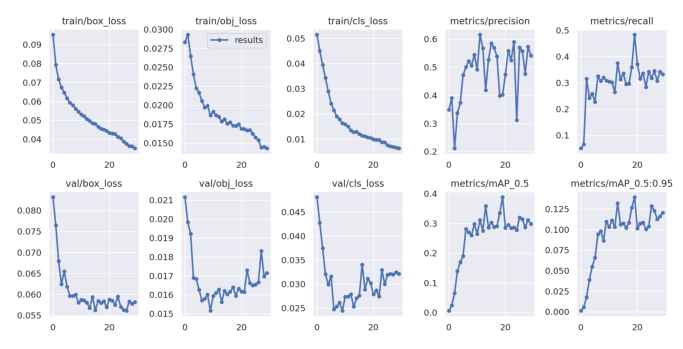


Displaying the ground truths vs predictions for three example batches from the validation set:


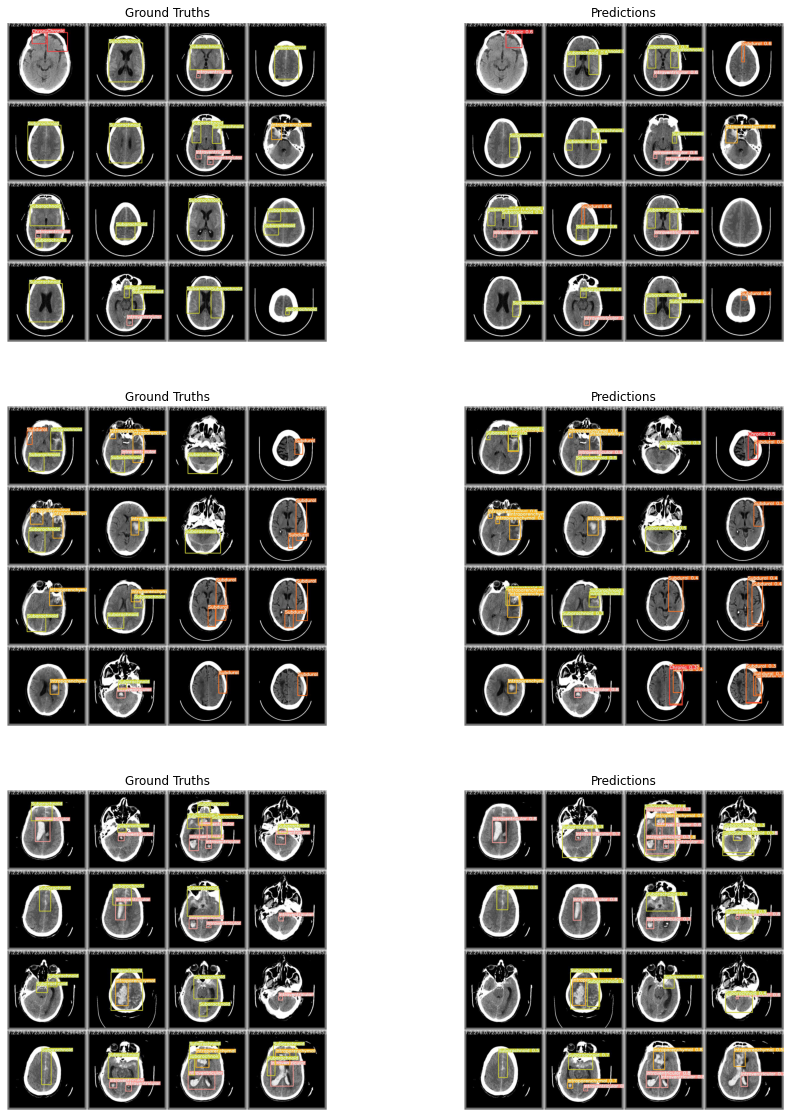

In [27]:
Show_performance(RUN)

**Please note that the best mAP of our model has been about 0.4. Though not very bad, this mAP is not very high. Rather than the training hyperparameters, What other factors do you think can explain this phenomenon?**

### Part 7: Inference
As the final part of our notebook, let's apply our YOLO model to a set of images. For doing this, we separate a part of images that our model had not seen during the training (Please note that these images are different than the validation images you created above, as we are now working with a model that we had trained before; not a model that you trained here). 

In [32]:
# Seperating a part of our images which our pre-trained model has not seen for training

inference_imgs_dir = 'Inference_imgs'
os.makedirs(inference_imgs_dir, exist_ok=True)

with open(f'{PROJECT_dir}/{RUN}/images_for_inference.txt', 'r') as f:
  inference_img_names = [line.strip() for line in f.readlines()]

# Copying 20 images for inference to the inference_imgs_dir

count_copied = 0
for image in os.listdir('images'):
  if image in inference_img_names:
    shutil.copy(f'images/{image}', f'{inference_imgs_dir}/{image}')
    count_copied += 1
  if count_copied == 20:
    break

In [29]:
# Setting up the pipeline for inference

weights_path = f'{PROJECT_dir}/{RUN}/weights/best.pt'
destination_dir = 'Inference_Results'
output_name = 'Pretrained_YOLOv5_Results'
img_size = 512
conf: float = 0.222
iou_threshold: float = 0.5
max_dt = 5

In [33]:
# We should now run the detect.py code from the model directory and pass all 
# the arguments that YOLO needs. 

!python {model_dir}/detect.py  --weights {weights_path} \
                               --source {inference_imgs_dir} \
                               --project {destination_dir} \
                               --name {output_name}\
                               --img {img_size} \
                               --conf {conf} \
                               --iou-thres {iou_threshold} \
                               --max-det {max_dt} \
                               --save-txt \
                               --save-conf \
                               --exist-ok

detect: weights=['yolov5/RSNA_YOLO_Project/Exp1/weights/best.pt'], source=Inference_imgs, imgsz=[512, 512], conf_thres=0.222, iou_thres=0.5, max_det=5, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=Inference_Results, name=Pretrained_YOLOv5_Results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-385-gd7aa3f1 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 476 layers, 87232339 parameters, 0 gradients
image 1/20 /content/Inference_imgs/1.2.276.0.7230010.3.1.4.296485376.1.1521713311.1777984.png: 512x512 1 Intraparenchymal, Done. (2.585s)
image 2/20 /content/Inference_imgs/1.2.276.0.7230010.3.1.4.296485376.1.1521713340.1784894.png: 512x512 1 Intraventricular, 1 Subarachnoid, Done. (2.610s)
image 3/20 /content/Inference_imgs/1.2.276.0.7230010.3.1.

Before we wrap up this notebook, we can also visualize some of the YOLO predictions!

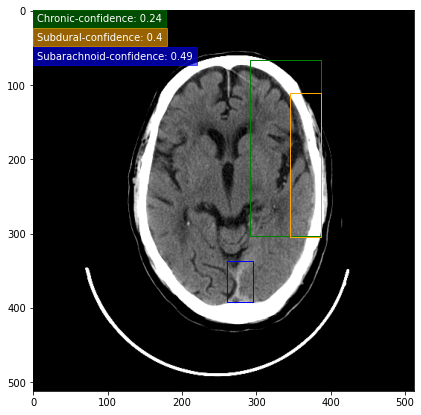

In [55]:
def Show_prediction(img_path):
  """
  A function to plot an image and show the bounding boxes predicted by YOLO for that image.
  """
  index_to_label_dict = {value: key for key, value in label_to_index_dict.items()}
  fig, ax = plt.subplots(1, 1, figsize=(7, 7))
  ax.imshow(imread(img_path), cmap='gray')
  label_path = f'{destination_dir}/{output_name}/labels/{img_path.split("/")[-1][:-4]}.txt'
  with open(label_path, 'r') as f:
    for i, line in enumerate(f.readlines()):
        line = [float(value) for value in line.strip().split(' ')]
        label = index_to_label_dict[int(line[0])]
        color = label_color_dict[label]
        confidence = round(float(line[-1]), 2)
        x_min = (line[1] - line[3]/2) * 512
        y_min = (line[2] - line[4]/2) * 512
        width = line[3] * 512
        height = line[4] * 512 
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(5, 15+i*25, f'{label}-confidence: {confidence}', color='w', fontsize=10, bbox={'alpha':0.6,'color':color})

# Now we build a list of all paths to images we had split for validaiton of our model
# And then feed them to the function we defined above.
# Feel free to visualize the predictions for multple images and see how the results 
# look like!
img_paths = [os.path.join(inference_imgs_dir, img) for img in os.listdir(inference_imgs_dir)]
Show_prediction(img_paths[3])

That's it! Congratulations for training and applying your first YOLOv5 model. Hopefully you have learned how to train more YOLO models on your custom datasets. 

**Thank you for attending this workshop!**